In [1]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import os
from os.path import join as pjoin
from matplotlib import pyplot as plt
import random
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,AveragePooling1D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
warnings.filterwarnings('ignore')

C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\razer\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# first we can see what does the feature look like
def get_raw_feature():
    video_data_dir='new23feature'
    X=[]
    Y=[]
    for video in os.listdir(video_data_dir):
        each_video= pjoin(video_data_dir,video)
        ## 'C:\\videofeature\\' using
#         l=each_video.split('t_')[1]

        # 'C:\\new_video_feature\\' using
        l=each_video.split('e_')[1]
        l=l.split('.')[0]
        LABEL=int(l)
        X.append(np.load(each_video))
        Y.append(LABEL)
#     Video_label=pd.read_csv('label.csv')
# #     Video_label=np.array(Video_label)[:,:-1]
    return X,Y


## 1 Read features from 19 npy files

In [4]:
X,Y=get_raw_feature()
Video_label=pd.read_csv('newall_label.csv')
# Video_label=np.array(Video_label)[:,:-1]
print('there are ',len(X),'videos')
print('feature of video [0]',X[0].shape)
print('video [0] is from video' ,Y[0])
print(Y)

there are  23 videos
feature of video [0] (153, 14)
video [0] is from video 11
[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [5]:
# Video_label

In [6]:
range_label=pd.read_csv('range_label.csv')
range_label.head()

,VideoNum,DP,BD,E,FS,A,RC
0,11,3,2,2,2,4,3
1,11,2,2,3,1,3,3
2,11,1,1,1,1,1,1
3,16,1,1,1,1,1,1
4,16,2,1,1,1,1,2


In [7]:
counts=range_label['VideoNum'].value_counts()
# counts

In [8]:
def get_review_times(videoNum):
    counts=range_label['VideoNum'].value_counts()
    times=int(counts[counts.index==videoNum])
    return times
get_review_times(192)

1

In [9]:
r_group=range_label.groupby(['VideoNum'])
r_max=r_group.max()
r_min=r_group.min()
r_max=r_max.reset_index()
r_min=r_min.reset_index()

In [10]:
def get_video_range(videoNum):
    vmax=r_max[r_max['VideoNum']==videoNum]
    vmin=r_min[r_min['VideoNum']==videoNum]
    return vmax,vmin

In [11]:
# a,i=get_video_range(11)

Video_label contains detail labels and we can use Y to index them later.

In [12]:
def getlabel(number):
    L=Video_label[Video_label['label']==number]
    L=np.array(L)[:,:-1]
    L= np.squeeze(L)
    return L
# def getlabel_addnoise(number):
#     L=Video_label[Video_label['label']==number]
#     L=np.array(L)[:,:-1]
#     L= np.squeeze(L)
#     noise=np.array([random.uniform(-0.4, 0.4) for _ in range(len(L))])
# #     print(noise)
#     return L+noise

Here we create two functions to sample video clips from each video and get their time differences.


In [13]:
def get_diff_and_hstack_to_orginal_data(X,time_lag=2,move_threshold=200):
    original=X[:-time_lag]
    modified=X[time_lag:]
    result=modified-original
    ## threshold
    # consider there was no top in the first image and it showed up in the next image
    # the difference would be huge, which was not ideal.
    # so we need to filter these extrem value 
    result[np.abs(result)>move_threshold]=0
    
    return np.hstack((X[time_lag:],result))

##from each video sample video clips with size=window_L. you can specify stride 
def make_video_clips(matrix,window_L,stride):
    alldata=[]

    total_frame=matrix.shape[0]
    index=[n for n in range(1,total_frame,stride)]
    for start_index in index:
        if start_index+window_L> total_frame:
            break
#         print(start_index)
        each_clip_data=matrix[start_index:start_index+window_L]
#         each_clip_data=np.transpose(each_clip_data)
#         print(each_clip_data.shape)
        alldata.append(each_clip_data)
    return np.array(alldata)

## 2 pre-processing the feature
make new 28-d feature and  sample video clips

In [14]:
####################################### set video clips parameters
############################################### make new 28-d feature
video_clips_length=30
time_lag=2
move_threshold=150
stride=video_clips_length

####################################### set video clips parameters
############################################### make new 28-d feature
all_data=[]
for each_video,label in zip(X,Y):

    re=get_diff_and_hstack_to_orginal_data(each_video,time_lag,move_threshold)
#     re=each_video
    video_clip=make_video_clips(re,video_clips_length,stride)
    print(video_clip.shape)
    all_data.append((video_clip))


(5, 30, 28)
(4, 30, 28)
(10, 30, 28)
(20, 30, 28)
(10, 30, 28)
(100, 30, 28)
(40, 30, 28)
(19, 30, 28)
(100, 30, 28)
(5, 30, 28)
(100, 30, 28)
(10, 30, 28)
(10, 30, 28)
(5, 30, 28)
(20, 30, 28)
(40, 30, 28)
(99, 30, 28)
(9, 30, 28)
(20, 30, 28)
(40, 30, 28)
(20, 30, 28)
(10, 30, 28)
(10, 30, 28)


So there are 19 videos and you can see how many video clips they have.

And next we will use leave one method to train the model.

## 3 prepare leave one data and give every video clips their label

In [15]:
# this function is used to stack 18 videos into a big matrix
# the dimenstion will be 
# (n1+n2..+n18,28,30)
# and the label will be (n1+n2..+n18,6)

def stack_video_clips_get_label(data,label):
    final_data=data[0]

    final_label=[getlabel(label[0]) for _ in range(final_data.shape[0])]
#     print(len(final_label))
#     print(final_data.shape)
    for i in range(1,len(data)):
        final_data=np.vstack((final_data,data[i]))
        for j in range(data[i].shape[0]):
            final_label.append(getlabel(label[i]))
    return final_data,np.array(final_label)

########## leave one and stack all video clips
def hold_out(X,Y,hold_number):
        new_label=Y.copy()
        new_data=X.copy()
        # find video n 's index
        index=new_label.index(hold_number)
        # get the video n and it's label
        X_test=new_data[index]
        test_label=getlabel(hold_number)
        y_test=np.array([test_label for _ in range(X_test.shape[0])])
#         # so we can del them 
        del new_label[index]
        del new_data[index]
#         print(new_label)
        final_data_X,final_data_Y=stack_video_clips_get_label(new_data,new_label)
        return final_data_X,X_test,final_data_Y,y_test

In [16]:
# for each col, calculate the weighted average
def get_weighted_average(df):
    length=len(df)
    top=int(1/6*length)
    bottom=length-top
    df=np.array(df)
    df=np.sort(df)
    weghted_sum=np.sum(df[:top]*(1/6))+np.sum(df[top+1:bottom]*(2/3))+np.sum(df[bottom+1:]*(1/6))
    weghted_sum=weghted_sum/length
    return weghted_sum

# make the data frame
# Plot_data is the pridect result, which will have 6 scores
def get_video_score(Plot_data,GT,poolingweight):
    weight_ave_re=[]
    mean_re=[]
    median_re=[]
    pooled_re=[]
    
    for i in Plot_data.columns:
        weight_ave=get_weighted_average(Plot_data[i])
        weight_ave_re.append(weight_ave)
        
        mean_value=np.mean(Plot_data[i])   
        mean_re.append(mean_value)
        
        median_value = np.median(Plot_data[i])
        median_re.append(median_value)
        
        weight_ave_wight=poolingweight[0]
        mean_value_wight=poolingweight[1]
        median_value_wight=poolingweight[2]
        # pooling is also a weighted average 
        pooling = (weight_ave*weight_ave_wight + mean_value*mean_value_wight + median_value*median_value_wight)
        pooled_re.append(pooling)
        
    video_result=pd.DataFrame([weight_ave_re,mean_re,median_re,pooled_re,GT])
    video_result.columns = ['DP','BD','E','FS','A','RC']
    video_result.index = ['Weighted_average', 'Mean', 'Median','Cool_pooling','Ground_truth']
    return video_result

## 3 perform leave one cross validation  


In [17]:
from keras.layers import average, concatenate,RepeatVector,Lambda,add,subtract,Activation
from keras.models import Input, Model
from keras import backend as K
from keras.layers.normalization import BatchNormalization

In [18]:
# the model we will use
def make_model_1d_3layer(l2_lambda,clip_lenth,dimension):
    input_holder = Input(shape=(clip_lenth, dimension))
    x = Conv1D(filters=8, 
                     kernel_size=15, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(input_holder)
    x = BatchNormalization()(x)

    x = Conv1D(filters=8, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=8, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x= MaxPooling1D(2,padding='same')(x)
    
    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
#     x = GlobalMaxPooling1D()(x)
#     x = Flatten()(x)

#####_______________________________________________________________________
    u = GlobalMaxPooling1D()(x)
    u_broadcast=RepeatVector(x.shape[1])(u)
    
    def op(inputs):
        x, y = inputs
        return K.pow((x - y), 2) 

    Z=Lambda(op)([u_broadcast,x])

    v = GlobalMaxPooling1D()(Z)
    x = concatenate([u,v])
    
#####_______________________________________________________________________
#     x = Dense(16, 
#               activation='relu',
#               kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#             )(x)

#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers
    
#     x = Dense(6, 
#               activation='sigmoid', 
#               kernel_initializer='glorot_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
    
#####_______________________________________________________________________  
#     x = Dense(16,activation='relu',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers


#     x = Dense(32,activation='relu',kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers

#####______________________________Multi task_________________________________________  
# ['DP','BD','E','FS','A','RC']
    number_of_N=16
    DP=0.2
    
    y1 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Dropout(DP)(y1) # add some dropout for regularization after conv layers
    y1= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='DP'
#              kernel_regularizer=l2(l2_lambda)
             )(y1)

    y2 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = Dropout(DP)(y2) # add some dropout for regularization after conv layers
    y2= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='BD'
#              kernel_regularizer=l2(l2_lambda)
             )(y2)
    
    y3 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)
    y3 = Dropout(DP)(y3) # add some dropout for regularization after conv layers
    y3= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='E'
#              kernel_regularizer=l2(l2_lambda)
             )(y3)

    y4 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)
    y4 = Dropout(DP)(y4) # add some dropout for regularization after conv layers
    y4= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='FS'
#              kernel_regularizer=l2(l2_lambda)
             )(y4)
    
    y5 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = Dropout(DP)(y5) # add some dropout for regularization after conv layers
    y5= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='A'
#              kernel_regularizer=l2(l2_lambda)
             )(y5)
    
    y6 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y6 = BatchNormalization()(y6)
    y6 = Activation('relu')(y6)
    y6 = Dropout(DP)(y6) # add some dropout for regularization after conv layers
    y6= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='RC'
#              kernel_regularizer=l2(l2_lambda)
             )(y6)
#####______________________________Multi task_________________________________________  


    model = Model(inputs=input_holder,outputs=[y1,y2,y3,y4,y5,y6])
# ['DP','BD','E','FS','A','RC']
    losses = {
        "DP": "mean_squared_error",
        "BD": "mean_squared_error",
        "E": "mean_squared_error",
        "FS": "mean_squared_error",
        "A": "mean_squared_error",
        "RC": "mean_squared_error",
    }
    model.compile(#loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
                  loss=losses, 
              optimizer='adam') # 'adadelta' 'rmsprop'                  
#     model.summary()
    return model
te=make_model_1d_3layer(0.001,30,28)

In [19]:
# the model we will use
def make_model_1d(l2_lambda,clip_lenth,dimension):
    input_holder = Input(shape=(clip_lenth, dimension))
    x = Conv1D(filters=8, 
                     kernel_size=15, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(input_holder)
    x = BatchNormalization()(x)

    x = Conv1D(filters=8, 
                     kernel_size=10, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
#     x = Conv1D(filters=8, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x= MaxPooling1D(2,padding='same')(x)
    
    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                    kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=16, 
                     kernel_size=5, 
                     padding='same',
                     activation='relu', 
                     input_shape=(clip_lenth, dimension),
                     kernel_regularizer=l2(l2_lambda)
              )(x)
    x = BatchNormalization()(x)
#     x = Conv1D(filters=16, 
#                      kernel_size=5, 
#                      padding='same',
#                      activation='relu', 
#                      input_shape=(clip_lenth, dimension),
#                      kernel_regularizer=l2(l2_lambda))(x)

#     x = GlobalMaxPooling1D()(x)
#     x = Flatten()(x)

#####_______________________________________________________________________
    u = GlobalMaxPooling1D()(x)
    u_broadcast=RepeatVector(x.shape[1])(u)
    
    def op(inputs):
        x, y = inputs
        return K.pow((x - y), 2) 

    Z=Lambda(op)([u_broadcast,x])

    v = GlobalMaxPooling1D()(Z)
    x = concatenate([u,v])
    
#####_______________________________________________________________________
#     x = Dense(16, 
#               activation='relu',
#               kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#             )(x)

#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers
    
#     x = Dense(6, 
#               activation='sigmoid', 
#               kernel_initializer='glorot_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
    
#####_______________________________________________________________________  
#     x = Dense(16,activation='relu',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers


#     x = Dense(32,activation='relu',kernel_initializer='he_uniform',
#               kernel_regularizer=l2(l2_lambda)
#              )(x)
#     x = Dropout(0.5)(x) # add some dropout for regularization after conv layers

#####______________________________Multi task_________________________________________  
# ['DP','BD','E','FS','A','RC']
    number_of_N=16
    DP=0.2
    
    y1 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Dropout(DP)(y1) # add some dropout for regularization after conv layers
    y1= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='DP'
#              kernel_regularizer=l2(l2_lambda)
             )(y1)

    y2 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = Dropout(DP)(y2) # add some dropout for regularization after conv layers
    y2= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='BD'
#              kernel_regularizer=l2(l2_lambda)
             )(y2)
    
    y3 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)
    y3 = Dropout(DP)(y3) # add some dropout for regularization after conv layers
    y3= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='E'
#              kernel_regularizer=l2(l2_lambda)
             )(y3)

    y4 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)
    y4 = Dropout(DP)(y4) # add some dropout for regularization after conv layers
    y4= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='FS'
#              kernel_regularizer=l2(l2_lambda)
             )(y4)
    
    y5 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)
    y5 = Dropout(DP)(y5) # add some dropout for regularization after conv layers
    y5= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='A'
#              kernel_regularizer=l2(l2_lambda)
             )(y5)
    
    y6 = Dense(number_of_N,kernel_initializer='he_uniform',
             # kernel_regularizer=l2(l2_lambda)
             )(x)
    y6 = BatchNormalization()(y6)
    y6 = Activation('relu')(y6)
    y6 = Dropout(DP)(y6) # add some dropout for regularization after conv layers
    y6= Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',name='RC'
#              kernel_regularizer=l2(l2_lambda)
             )(y6)
#####______________________________Multi task_________________________________________  


    model = Model(inputs=input_holder,outputs=[y1,y2,y3,y4,y5,y6])
# ['DP','BD','E','FS','A','RC']
    losses = {
        "DP": "mean_squared_error",
        "BD": "mean_squared_error",
        "E": "mean_squared_error",
        "FS": "mean_squared_error",
        "A": "mean_squared_error",
        "RC": "mean_squared_error",
    }
    model.compile(#loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error' 'mean_absolute_percentage_error'
                  loss=losses, 
              optimizer='adam') # 'adadelta' 'rmsprop'                  
#     model.summary()
    return model
te=make_model_1d(0.001,30,28)

In [20]:
# from IPython.display import SVG
# from keras.utils import plot_model
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(te).create(prog='dot', format='svg'))

In [21]:
# te.summary()

In [22]:
# plot_model(te, to_file='model1.png')

In [23]:
# customized data generator
def generator_noise(data, label, batch_size=64,noise_range=0.1):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data.shape[0], size=batch_size)

        samples = data[rows]
        y=label[rows]
        noise=np.random.uniform(low=-noise_range, high=noise_range, size=(y.shape[0],y.shape[1]))
        y=y+noise
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield samples,labels
        
def generator(data, label, batch_size=64):
    while 1:
        DP = []  
        BD = []
        E = []
        FS = []
        A = []
        RC = []
        rows = np.random.randint(0, data.shape[0], size=batch_size)

        samples = data[rows]
        y=label[rows]
#         noise=np.random.uniform(low=-0.5, high=0.5, size=(y.shape[0],y.shape[1]))
#         y=y+noise
        for i in range(len(y)):
            DP.append(y[i][0])
            BD.append(y[i][1])
            E.append(y[i][2])
            FS.append(y[i][3])
            A.append(y[i][4])
            RC.append(y[i][5])
        labels = [np.array(DP),np.array(BD),np.array(E),np.array(FS), np.array(A),np.array(RC)]
        yield samples,labels

In [24]:
print(Y)

[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]


In [25]:
# ####un-comment the code blow to test all the video
# # def test_hold_out(model_name,hold_out_number,E,show_result=False,l2=0.001,noise_range=0.1):
# Diff_plot=[]
# E=20
# show_result=True
# l2lam=0.01
# noise_range=0.1

# total_loss=0
# model_name='CNN'
# # for i in [11, 113, 130]:
# for i in Y:
#     print('video',i)
#     loss,each_diff=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,pooling)
#     total_loss=total_loss+loss
#     Diff_plot.append(each_diff)
# print('total_loss= ',total_loss)

# Diff_plot=np.array(Diff_plot)
# Diff_plot=pd.DataFrame(Diff_plot)
# Diff_plot.columns = ['DP','BD','E','FS','A','RC']
# Diff_plot.plot.box()

In [34]:
def get_swarm_data(Diff_plot):
    name=['DP','BD','E','FS','A','RC']
    err=[]
    typen=[]
    for n in name:
        for record in Diff_plot[n]:
            err.append(record)
            typen.append(n)

    swarm_data = {'err': err, 'score_type':typen}
    swarm_data = pd.DataFrame(data=swarm_data)
    return swarm_data


In [35]:
def model_slection(model_name,E,l2lam,noise_range,poolingweight):  
    Diff_plot=[]
#     E=20
#     l2lam=0.01
#     noise_range=0.1
    show_result=False

    total_loss=0
    
#     for i in [11, 113, 130, 143]:
    for i in Y:
        print('video',i,end=' ')
        loss,each_diff=test_hold_out(model_name,i,E,show_result,l2lam,noise_range,poolingweight)
        total_loss=total_loss+loss
        Diff_plot.append(each_diff)

    ax=plt.figure(figsize=(16,5))
    
    Diff_plot=np.array(Diff_plot)
    Diff_plot=pd.DataFrame(Diff_plot)
    Diff_plot.columns = ['DP','BD','E','FS','A','RC']
    ax = plt.subplot(131)
    Diff_plot.plot.box(ax=ax)
    plt.ylim(0,4.5)
    print('total_loss= ',total_loss)
    

    bx = plt.subplot(132)
    swarm_data=get_swarm_data(Diff_plot)
    bx = sns.swarmplot(x="score_type", y="err", data=swarm_data,color="0.2")
    ax = sns.boxplot(x="score_type", y="err", data=swarm_data)
    plt.ylim(0,4.5)

    
    cx = plt.subplot(133)
    cx = sns.violinplot(x="score_type", y="err", data=swarm_data)
    plt.ylim(0,4.5)
    plt.show()
    
    print('all gear score abs error',np.sum(np.sum(Diff_plot)))
    print('each gear score abs error\n',np.sum(Diff_plot))
    weight=''
    for i in poolingweight:
        weight+=str(i)+'_'
        
    out_name='data//'+str(E)+'_'+str(l2lam)+'_'+str(noise_range)+'_'+str(weight)+'.npy'
    np.save(out_name,Diff_plot)

In [36]:
def predict_average_test_hold_out(model_name,hold_out_number,E,show_result=False,l2lambd=0.001,noise_range=0.1,poolingweight=[0.2,0.4,0.4]):
    # using leave one cv to get train/test data
    X_train, X_test, y_train, y_test=hold_out(all_data,Y,hold_out_number)
    
  
    GT=list(getlabel(hold_out_number))
    number_of_video_clips=X_test.shape[0]
    predict=np.zeros((number_of_video_clips,6))+3

#     #get pridect result
#     predict=np.array([3,3,3,3,3])
#     data={}
#     task=['DP','BD','E','FS','A','RC']

#     for i in range(len(predict)):
#         data[task[i]]=np.squeeze(predict[i])

    Plot_data=pd.DataFrame(predict,columns=['DP','BD','E','FS','A','RC'])
#     Plot_data=pd.DataFrame(data)
#     Plot_data=Plot_data*5

#         print(Plot_data)
#         print(Plot_data.shape)
#     video_result=get_video_score(Plot_data,GT,poolingweight)
    gt=np.array(GT)
    re=np.array([3,3,3,3,3,3])
    each_diff=np.abs(re-gt)
    each_diff_residual=list(re-gt)
    
    if show_result:
        ax=plt.figure(figsize=(15,5))
#         ax = plt.subplot(321)
#         ax.plot(model_h.history['loss'])
#         plt.ylabel('Training Loss')
#         plt.xlabel('epochs')

#         ax = plt.subplot(322)
#         ax.plot(model_h.history['val_loss'])
#         plt.ylabel('valadation Loss')
#         plt.xlabel('epochs')
#         print('loss',model_h.history['val_loss'][-1])
    
        y=[x for x in range(1,7)]
        ax = plt.subplot(131)
#         Plot_data.plot.box(ax=ax)

        
        ax.plot(y, re, label='predict')
        ax.plot(y, gt, label='ground truth')

        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        ax.legend()

        ax = plt.subplot(132)
        Plot_data.plot(ax=ax)
#         ax.plot(Plot_data)
        ax.legend(['DP','BD','E','FS','A','RC'])
#         ax.plot(Plot_data.BD)
        plt.ylabel('Gear Score')
        plt.xlabel('Video clips length')

        
        ax = plt.subplot(133)
        times=get_review_times(hold_out_number)
        ax.plot(y, np.round(re), label='predict-round')
        ax.plot(y, re, label='predict')
        
        
        plt.ylabel('Gear Score')
        plt.xlabel('Score type')
        plt.ylim(0,5.5)
        
        if times>1:
#             ax.plot(y, re, label='predict')
            
            vmax,vmin=get_video_range(hold_out_number)
#             print(vmax)
#             print(vmin)
            it=1
            for types in ['DP','BD','E','FS','A','RC']:
                Range=vmax[types]-vmin[types]
                rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
                ax.add_patch(rect)   
                it=it+1
        else:
#             new_re=np.round(video_result.iloc[3])
#             ax.plot(y, new_re, label='predict-round')
            
            ax.plot(y, gt, label='ground truth')            
           
        labels=['','DP','BD','E','FS','A','RC']
        ax.set_xticklabels(labels)
        ax.legend()
#         plt.savefig(str(hold_out_number)+'result.png')
        plt.show()
        
    return list(each_diff),each_diff_residual


In [37]:
####un-comment the code blow to test all the video
# def test_hold_out(model_name,hold_out_number,E,show_result=False,l2=0.001,noise_range=0.1):
Diff_plot=[]
residual=[]
# E=20
# show_result=False
# l2lam=0.01
# noise_range=0.1
# pooling=[0,1,0]
# total_loss=0
# model_name='CNN'
# # for i in [11, 113, 130]:
# for i in Y:
#     print('video',i,end=' ')
#     each_diff,each_diff_residual=predict_average_test_hold_out(model_name,i,E,show_result,l2lam,noise_range,pooling)
# #     total_loss=total_loss+loss
#     Diff_plot.append(each_diff)
#     residual.append(each_diff_residual)
# # print('total_loss= ',total_loss)

# Diff_plot=np.array(Diff_plot)
# Diff_plot=pd.DataFrame(Diff_plot)
# Diff_plot.columns = ['DP','BD','E','FS','A','RC']
# baseline_residual=pd.DataFrame(residual)
# baseline_residual.columns = ['DP','BD','E','FS','A','RC']
# # Diff_plot.plot.box()

In [30]:
# residual=pd.DataFrame(residual)
# residual.columns = ['DP','BD','E','FS','A','RC']
# residual

In [38]:
def convert_to_df(data,colnum):
    loss=0
    result=[]    
    for i in range(len(data)):
        loss+=np.sum(data[i][colnum])
        result.append(data[i][colnum])
 
    result=pd.DataFrame(result)
    result.columns = ['DP','BD','E','FS','A','RC']
    return loss,result

In [39]:
best=np.load('data\Diff19_0.01_0.1_0.333333_0.333333_0.333333_fsize6.npy')
best_residual=np.load('data\Residual19_0.01_0.1_0.333333_0.333333_0.333333_fsize6.npy')

best_loss,best_res=convert_to_df(best,3)
_,residual=convert_to_df(best_residual,3)
_,residual_noround=convert_to_df(best_residual,2)
print(best_loss)

121.333333334


In [40]:
# best=np.load('newdata\Diff10_1e-05_0.2_0.333333_0.333333_0.333333_fsize5.npy')
# best_residual=np.load('newdata\Residual10_1e-05_0.2_0.333333_0.333333_0.333333_fsize5.npy')

# best_loss,best_res=convert_to_df(best,3)
# _,residual=convert_to_df(best_residual,3)
# # _,residual_noround=convert_to_df(best_residual,2)
# print(best_loss)

In [41]:
ax=plt.figure(figsize=(16,5))
sns.set(style="whitegrid")
Diff_plot=np.array(Diff_plot)
Diff_plot=pd.DataFrame(Diff_plot)
Diff_plot.columns = ['DP','BD','E','FS','A','RC']
ax = plt.subplot(131)



bx = plt.subplot(132)
swarm_data=get_swarm_data(best_res)

bx = sns.swarmplot(x="score_type", y="err", data=swarm_data,color="0.2")
ax = sns.boxplot(x="score_type", y="err", data=swarm_data)
plt.ylim(0,4.5)


cx = plt.subplot(133)
cx = sns.violinplot(x="score_type", y="err", data=swarm_data)
plt.ylim(0,4.5)



plt.show()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 6 elements

<Figure size 1152x360 with 0 Axes>

In [33]:
# Y=[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]
# gt=Video_label[Video_label['label'].isin(Y)]
# # Filtered_data[Filtered_data['target'].isin(top_target)]
# gt=gt.drop(['label'], axis=1)
# gt.columns = ['DP','BD','E','FS','A','RC']

In [36]:
# getlabel(11)

In [37]:
# best_residual.iloc[1]


In [ ]:
Y=[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]
# Y=[11, 113,130]

for i,index in zip(Y,range(len(Y))):
    print(i)
    ax=plt.figure(figsize=(18,3))
    
    gt=getlabel(i)
    re=gt+residual.iloc[index]
    re_none_round=gt+residual_noround.iloc[index]

    
    y=[x for x in range(1,7)]
    ax = plt.subplot(141)
#     Plot_data.plot.box(ax=ax)
#     ax.plot(y, re, label='predict-round')
    ax.plot(y, re_none_round, label='predict')
    ax.plot(y, gt, label='ground truth')

    plt.ylabel('Gear Score')
    plt.xlabel('Score type')
    plt.ylim(0,5.5)
    ax.legend()
    
    ax = plt.subplot(142)
    times=get_review_times(i)
#     ax.plot(y, np.round(fi_re), label='predict-round')
    ax.plot(y, re, label='predict-round')
    ax.plot(y, re_none_round, label='predict')
    plt.ylabel('Gear Score')
    plt.xlabel('Score type')
    plt.ylim(0,5.5)

    if times>1:        
        vmax,vmin=get_video_range(i)

        it=1
        for types in ['DP','BD','E','FS','A','RC']:
            Range=vmax[types]-vmin[types]
            rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
            ax.add_patch(rect)   
            it=it+1
    else:
    #             new_re=np.round(video_result.iloc[3])
    #             ax.plot(y, new_re, label='predict-round')
        ax.plot(y, gt, label='ground truth')        
    labels=['','DP','BD','E','FS','A','RC']
    ax.set_xticklabels(labels)
    ax.legend()            
    
    


#     ax = plt.subplot(143)
# #     Plot_data.plot.box(ax=ax)
#     re=gt+residual_noround.iloc[index]
#     ax.plot(y, re, label='predict')
#     ax.plot(y, gt, label='ground truth')

#     plt.ylabel('Gear Score')
#     plt.xlabel('Score type')
#     plt.ylim(0,5.5)
#     ax.legend()
    
#     ax = plt.subplot(144)
#     times=get_review_times(i)
# #     ax.plot(y, np.round(fi_re), label='predict-round')
#     ax.plot(y, re, label='predict')
#     plt.ylabel('Gear Score')
#     plt.xlabel('Score type')
#     plt.ylim(0,5.5)

#     if times>1:        
#         vmax,vmin=get_video_range(i)

#         it=1
#         for types in ['DP','BD','E','FS','A','RC']:
#             Range=vmax[types]-vmin[types]
#             rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
#             ax.add_patch(rect)   
#             it=it+1
#     else:
#     #             new_re=np.round(video_result.iloc[3])
#     #             ax.plot(y, new_re, label='predict-round')
#         ax.plot(y, gt, label='ground truth')        
#     labels=['','DP','BD','E','FS','A','RC']
#     ax.set_xticklabels(labels)
#     ax.legend()            
    
#     ax = plt.subplot(424)
#     Plot_data.plot(ax=ax)
#     #         ax.plot(Plot_data)
#     ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#     #         ax.plot(Plot_data.BD)
#     plt.ylabel('Gear Score')
#     plt.xlabel('Video clips length')



    plt.show()


11


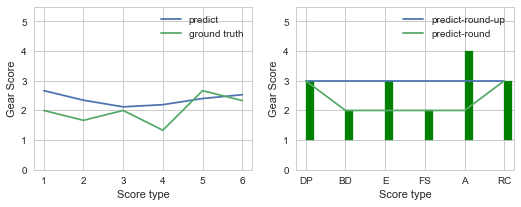

113


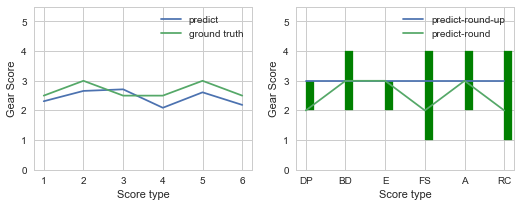

130


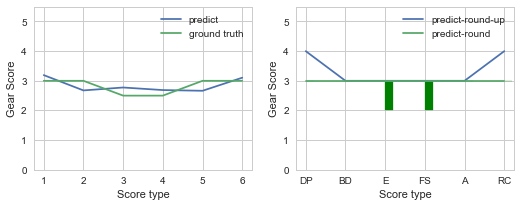

143


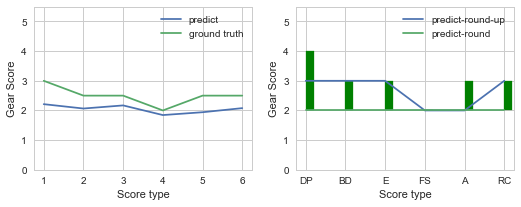

152


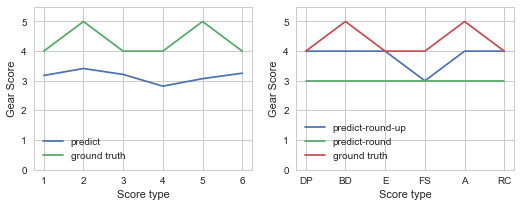

16


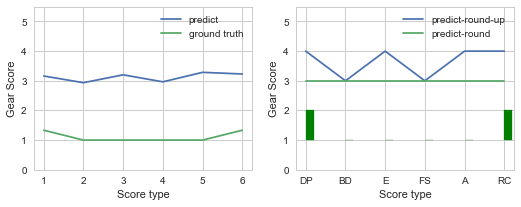

164


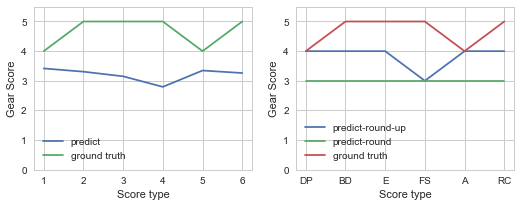

171


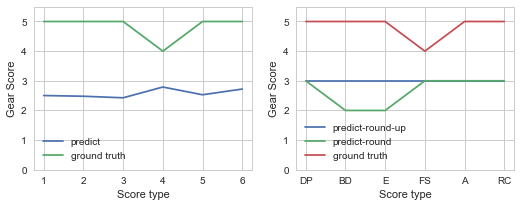

176


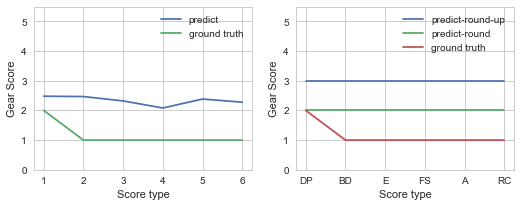

192


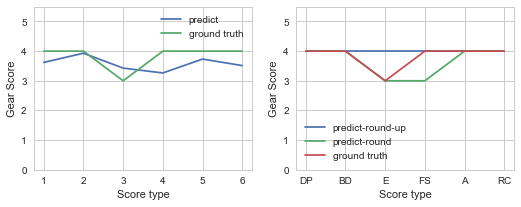

194


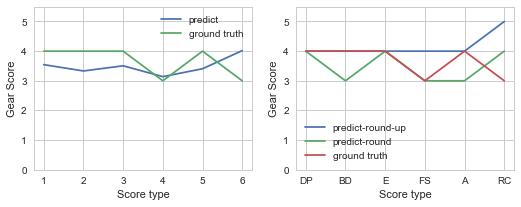

207


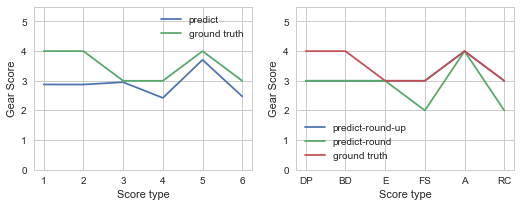

236


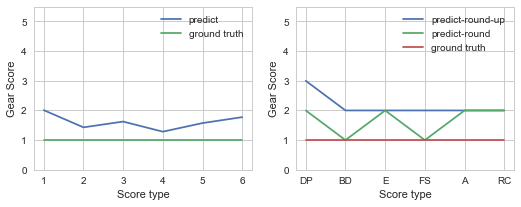

237


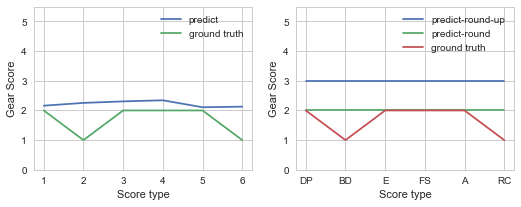

240


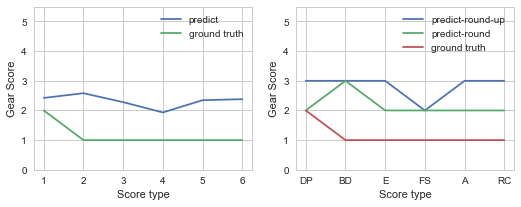

253


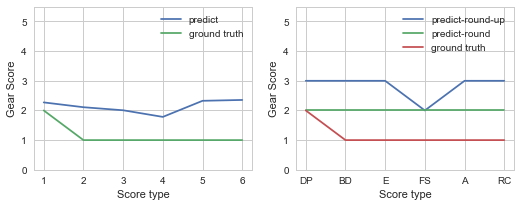

257


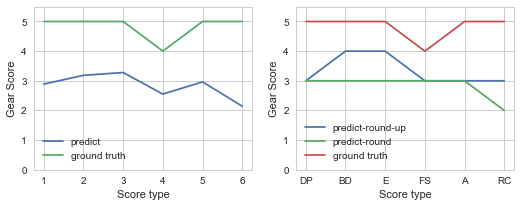

258


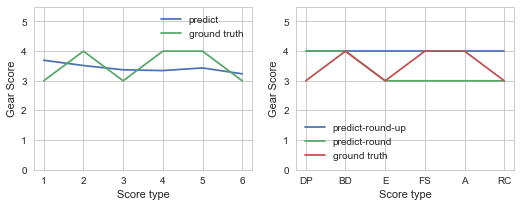

49


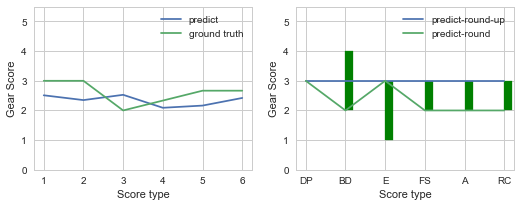

59


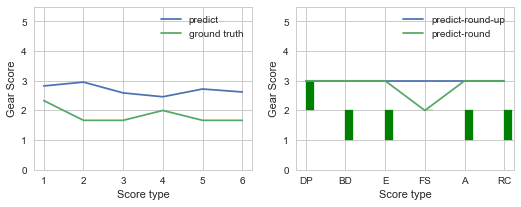

74


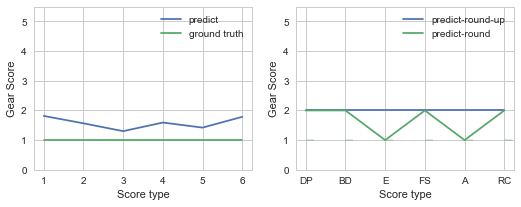

78


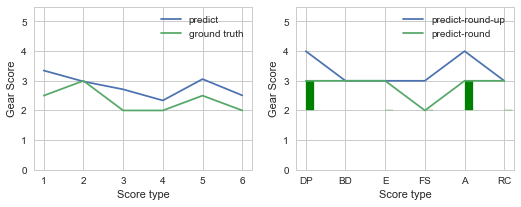

91


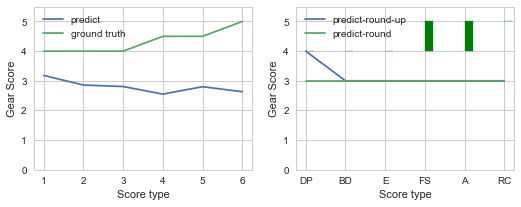

121.333333334
139.666666666


In [39]:
Y=[11, 113, 130, 143, 152, 16, 164, 171, 176, 192, 194, 207, 236, 237, 240, 253, 257, 258, 49, 59, 74, 78, 91]
# Y=[11, 113,130]
loss_round=0
loss_round_up=0

for i,index in zip(Y,range(len(Y))):
    print(i)
    ax=plt.figure(figsize=(18,3))
    
    gt=getlabel(i)
    re=gt+residual.iloc[index]
    re_none_round=gt+residual_noround.iloc[index]
    

    

    
    y=[x for x in range(1,7)]
    ax = plt.subplot(141)
#     Plot_data.plot.box(ax=ax)
#     ax.plot(y, re, label='predict-round')
    ax.plot(y, re_none_round, label='predict')
    ax.plot(y, gt, label='ground truth')

    plt.ylabel('Gear Score')
    plt.xlabel('Score type')
    plt.ylim(0,5.5)
    ax.legend()
    
    ax = plt.subplot(142)
    times=get_review_times(i)
#     ax.plot(y, np.round(fi_re), label='predict-round')
    ax.plot(y, np.ceil(re_none_round), label='predict-round-up')
    ax.plot(y, re, label='predict-round')
    loss_round+=np.abs(gt-re)
    loss_round_up+=np.abs(gt-np.ceil(re_none_round))

    plt.ylabel('Gear Score')
    plt.xlabel('Score type')
    plt.ylim(0,5.5)

    if times>1:        
        vmax,vmin=get_video_range(i)

        it=1
        for types in ['DP','BD','E','FS','A','RC']:
            Range=vmax[types]-vmin[types]
            rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
            ax.add_patch(rect)   
            it=it+1
    else:
    #             new_re=np.round(video_result.iloc[3])
    #             ax.plot(y, new_re, label='predict-round')
        ax.plot(y, gt, label='ground truth')        
    labels=['','DP','BD','E','FS','A','RC']
    ax.set_xticklabels(labels)
    ax.legend()            
    
    


#     ax = plt.subplot(143)
# #     Plot_data.plot.box(ax=ax)
#     re=gt+residual_noround.iloc[index]
#     ax.plot(y, re, label='predict')
#     ax.plot(y, gt, label='ground truth')

#     plt.ylabel('Gear Score')
#     plt.xlabel('Score type')
#     plt.ylim(0,5.5)
#     ax.legend()
    
#     ax = plt.subplot(144)
#     times=get_review_times(i)
# #     ax.plot(y, np.round(fi_re), label='predict-round')
#     ax.plot(y, re, label='predict')
#     plt.ylabel('Gear Score')
#     plt.xlabel('Score type')
#     plt.ylim(0,5.5)

#     if times>1:        
#         vmax,vmin=get_video_range(i)

#         it=1
#         for types in ['DP','BD','E','FS','A','RC']:
#             Range=vmax[types]-vmin[types]
#             rect = Rectangle((it, vmin[types]), 0.2, Range, color='green')
#             ax.add_patch(rect)   
#             it=it+1
#     else:
#     #             new_re=np.round(video_result.iloc[3])
#     #             ax.plot(y, new_re, label='predict-round')
#         ax.plot(y, gt, label='ground truth')        
#     labels=['','DP','BD','E','FS','A','RC']
#     ax.set_xticklabels(labels)
#     ax.legend()            
    
#     ax = plt.subplot(424)
#     Plot_data.plot(ax=ax)
#     #         ax.plot(Plot_data)
#     ax.legend(['DP','BD','E','FS','A','RC'],bbox_to_anchor=(1,1))
#     #         ax.plot(Plot_data.BD)
#     plt.ylabel('Gear Score')
#     plt.xlabel('Video clips length')



    plt.show()
print(np.sum(loss_round))
print(np.sum(loss_round_up))

In [40]:
import scipy.stats as stats
import scipy

In [41]:
for index, row in residual.iteritems():
    print(index)
    our=residual[index]
    base=baseline_residual[index]
    print(stats.f_oneway(our,base))

DP
F_onewayResult(statistic=0.469817767624863, pvalue=0.49666658532606833)
BD
F_onewayResult(statistic=0.6760563380495931, pvalue=0.4153816469788305)
E
F_onewayResult(statistic=1.063951174228701, pvalue=0.3079523933745774)
FS
F_onewayResult(statistic=3.1917098444871357, pvalue=0.08090387732608169)
A
F_onewayResult(statistic=0.8300255453097548, pvalue=0.36722956005246066)
RC
F_onewayResult(statistic=0.9365255474276462, pvalue=0.3384625166098387)


In [42]:
vector_residual=np.array(residual)
vector_residual=vector_residual.reshape(-1)
vector_residual.shape

vector_bsaeline_residual=np.array(baseline_residual)
vector_bsaeline_residual=vector_bsaeline_residual.reshape(-1)
vector_bsaeline_residual.shape

(138,)

In [43]:
stats.f_oneway(vector_residual,vector_bsaeline_residual)

F_onewayResult(statistic=6.438480714274286, pvalue=0.011722134322308588)

T-test

In [44]:
stats.ttest_ind(vector_residual, vector_bsaeline_residual, axis=0, equal_var=True)

Ttest_indResult(statistic=-2.537416149210508, pvalue=0.011722134322308784)

scipy.stats.jarque_bera

Note that this test only works for a large enough number of data samples (>2000) as the test statistic asymptotically has a Chi-squared distribution with 2 degrees of freedom.

In [45]:
for index, row in residual.iteritems():
    print(index)
    our=residual[index]
    base=baseline_residual[index]
    print('ours:',stats.jarque_bera(our))
    print('baseline:',stats.jarque_bera(base))

DP
ours: (0.5027449095554586, 0.7777326473674189)
baseline: (0.9287847470428562, 0.6285168926920257)
BD
ours: (0.5822642637308207, 0.7474169139022181)
baseline: (2.0793810145793823, 0.35356409053597626)
E
ours: (2.99736635817129, 0.22342417615066146)
baseline: (1.7233648726387532, 0.42245073762534135)
FS
ours: (0.38152253754442406, 0.826329835341874)
baseline: (1.7954219141609604, 0.4075013811097917)
A
ours: (0.5836817126231285, 0.7468873889296777)
baseline: (1.7543008492119263, 0.4159665524965087)
RC
ours: (2.2673943376813526, 0.3218411529938421)
baseline: (1.707697494669258, 0.42577308142922143)


In [46]:
stats.jarque_bera(vector_residual)

(4.282095422666, 0.11753163926162091)

In [47]:
stats.jarque_bera(vector_bsaeline_residual)

(9.456755688203994, 0.008840800571007001)

In [48]:
np.sum(vector_bsaeline_residual)

38.666666666000005

In [49]:
np.sum(vector_residual)

-14.333333333999995

In [50]:
import statsmodels.api as sm


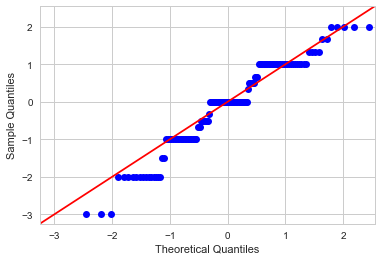

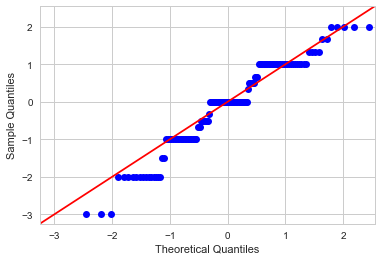

In [51]:
sm.qqplot(vector_residual, line='45')

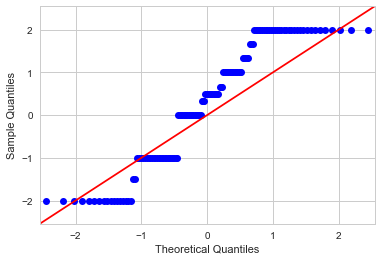

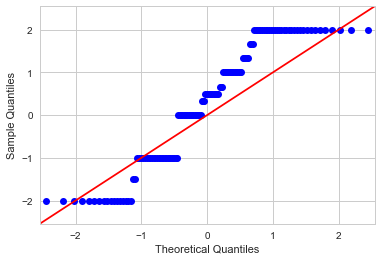

In [52]:
sm.qqplot(vector_bsaeline_residual, line='45')

In [53]:
ave_score=[6.0,
 2.0,
 1.0,
 3.0,
 8.0,
 11.333333334,
 10.0,
 11.0,
 11.0,
 5.0,
 4.0,
 3.0,
 12.0,
 8.0,
 11.0,
 11.0,
 11.0,
 3.0,
 2.333333333,
 6.999999999000002,
 12.0,
 4.0,
 8.0]